# 02 - DU

In [1]:
import findspark
from common.const import DATASET, FILEPATH
from common.dataframe_utils import string_columns_encoder
from common.utils import (change_case, describe_dataframe_details,
                          plot_column_value_count,
                          plt_group_by_2_columns_and_sum, rename_columns,
                          scatter_plot)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import (DecisionTreeRegressor, GBTRegressor,
                                   RandomForestRegressor)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, monotonically_increasing_id
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

In [2]:
findspark.init("/home/ubuntu/spark-3.2.1-bin-hadoop2.7")
spark = SparkSession.builder.appName("basics").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 22:57:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/23 22:57:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/23 22:57:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
df = spark.read.csv(FILEPATH.RAW, header=True, inferSchema=True)

## 2.2 Describing Data

In [4]:
df.printSchema()

root
 |-- Body Type: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Diet: string (nullable = true)
 |-- How Often Shower: string (nullable = true)
 |-- Heating Energy Source: string (nullable = true)
 |-- Transport: string (nullable = true)
 |-- Vehicle Type: string (nullable = true)
 |-- Social Activity: string (nullable = true)
 |-- Monthly Grocery Bill: integer (nullable = true)
 |-- Frequency of Traveling by Air: string (nullable = true)
 |-- Vehicle Monthly Distance Km: integer (nullable = true)
 |-- Waste Bag Size: string (nullable = true)
 |-- Waste Bag Weekly Count: integer (nullable = true)
 |-- How Long TV PC Daily Hour: integer (nullable = true)
 |-- How Many New Clothes Monthly: integer (nullable = true)
 |-- How Long Internet Daily Hour: integer (nullable = true)
 |-- Energy efficiency: string (nullable = true)
 |-- Recycling: string (nullable = true)
 |-- Cooking_With: string (nullable = true)
 |-- CarbonEmission: integer (nullable = true)



## 2.3 Data Exploration

In [5]:
df.show()

+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+-------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+--------------+
|  Body Type|   Sex|       Diet|How Often Shower|Heating Energy Source|   Transport|Vehicle Type|Social Activity|Monthly Grocery Bill|Frequency of Traveling by Air|Vehicle Monthly Distance Km|Waste Bag Size|Waste Bag Weekly Count|How Long TV PC Daily Hour|How Many New Clothes Monthly|How Long Internet Daily Hour|Energy efficiency|           Recycling|        Cooking_With|CarbonEmission|
+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------------

In [6]:
info_table = describe_dataframe_details(spark=spark, df=df)
info_table

summary,count,mean,stddev,min,max,outlier_count,null_count
Body Type,10100,None,None,fat,very fat,None,100
Sex,10200,None,None,f,male,None,0
Diet,10196,None,None,omnivore,vegetarian,None,4
How Often Shower,10187,None,None,daily,twice a day,None,13
Heating Energy Source,10200,None,None,coal,wood,None,0
Transport,10189,None,None,private,walk/bicycle,None,11
Vehicle Type,3344,None,None,diesel,petrol,None,6856
Social Activity,10195,None,None,never,sometimes,None,5
Monthly Grocery Bill,10200,176.39098039215688,140.2894374654016,1,8000,6,0
Frequency of Traveling by Air,10200,None,None,frequently,very frequently,None,0


In [7]:
# Rename columns to snake_case
df = rename_columns(df=df)
df.show()

+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type|   sex|       diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------

In [8]:
# Drop all Null value from pyspark dataframe except vehicle_type column
print("Count before drop null:", df.count())
no_null_df = df.na.fill("not_applicable", subset=["vehicle_type"]).na.drop()
print("Count after drop null:", no_null_df.count())

Count before drop null: 10200
Count after drop null: 10072


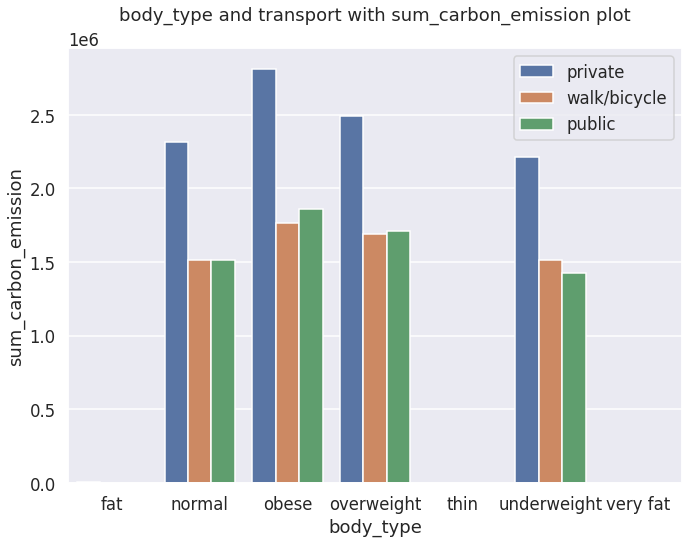

In [9]:
plt_group_by_2_columns_and_sum(
    df=no_null_df,
    group_by=["body_type", "transport"],
    sum_column=change_case(DATASET.TARGET),
)

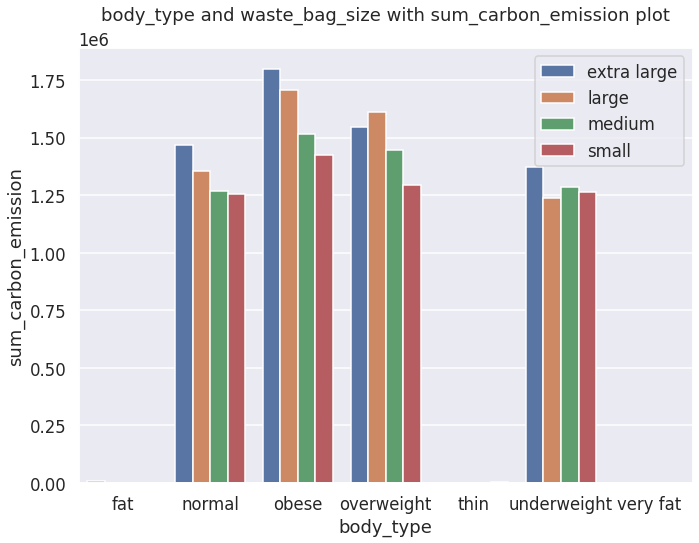

In [10]:
plt_group_by_2_columns_and_sum(
    df=no_null_df,
    group_by=["body_type", "waste_bag_size"],
    sum_column=change_case(DATASET.TARGET),
)

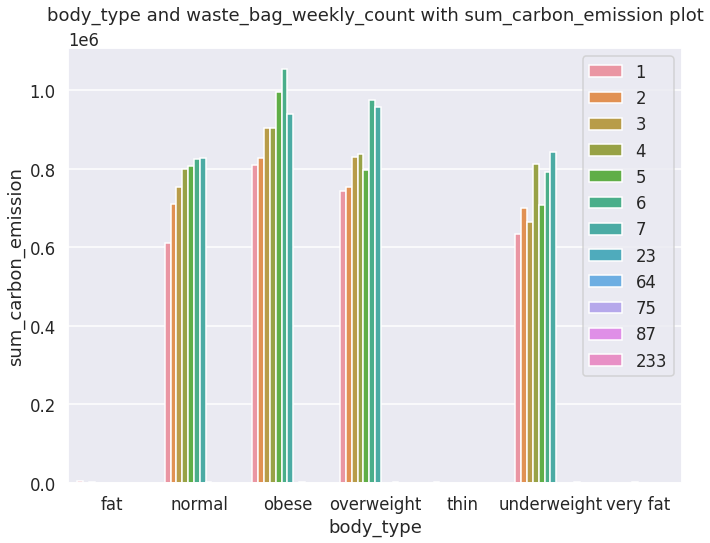

In [11]:
plt_group_by_2_columns_and_sum(
    df=no_null_df,
    group_by=["body_type", "waste_bag_weekly_count"],
    sum_column=change_case(DATASET.TARGET),
)

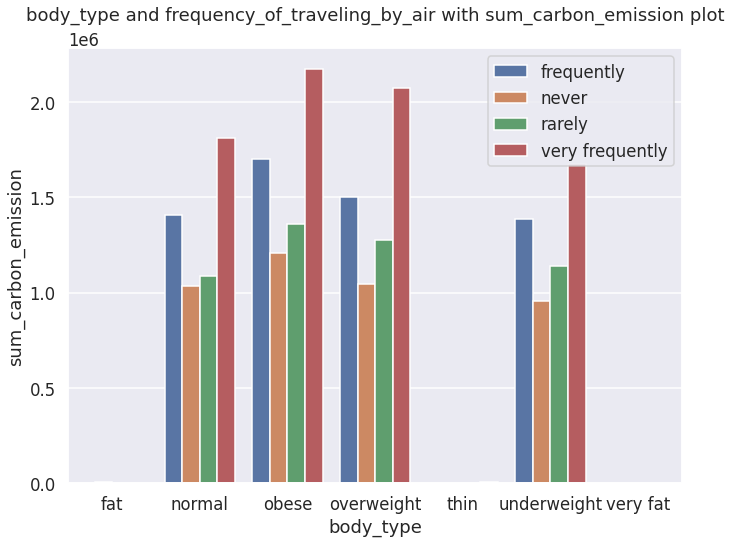

In [12]:
plt_group_by_2_columns_and_sum(
    df=no_null_df,
    group_by=["body_type", "frequency_of_traveling_by_air"],
    sum_column=change_case(DATASET.TARGET),
)

In [13]:
df_encode = string_columns_encoder(df=no_null_df)
feature_columns = df_encode.columns.copy()
feature_columns.remove(change_case(DATASET.TARGET))
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
vec_df = vec_assembler.transform(df_encode)
vec_df.show()

24/05/23 22:58:16 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------------------+----------------------+---------------------------+----------------------------+----------------------------+---------------+---------+---+----+----------------+---------------------+---------+------------+---------------+-----------------------------+--------------+-----------------+---------+------------+--------------------+
|monthly_grocery_bill|vehicle_monthly_distance_km|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|carbon_emission|body_type|sex|diet|how_often_shower|heating_energy_source|transport|vehicle_type|social_activity|frequency_of_traveling_by_air|waste_bag_size|energy_efficiency|recycling|cooking_with|            features|
+--------------------+---------------------------+----------------------+---------------------------+----------------------------+----------------------------+---------------+---------+---+----+----------------+---------------------+-------

In [14]:
ml_models = {
    "dt": DecisionTreeRegressor,
    "gbt": GBTRegressor,
    "rf": RandomForestRegressor,
}
feature_importances = {}
for model_name, ml_model in ml_models.items():
    dt = ml_model(featuresCol="features", labelCol=change_case(DATASET.TARGET))
    model = dt.fit(vec_df)
    feature_importances[f"{model_name}_importance"] = model.featureImportances

feature_importances_list = [
    (
        column_name,
        float(descision_tree_importance),
        float(gradient_boosted_tree),
        float(random_forest_importance),
    )
    for column_name, descision_tree_importance, gradient_boosted_tree, random_forest_importance in zip(
        vec_df.columns,
        feature_importances["dt_importance"],
        feature_importances["gbt_importance"],
        feature_importances["rf_importance"],
    )
]

fields = [
    StructField(f"{model_name}_importance", DoubleType(), True)
    for model_name in ml_models.keys()
]

fields.insert(0, StructField("feature", StringType(), True))
schema = StructType(fields)
feature_importances_df = spark.createDataFrame(feature_importances_list, schema=schema)

ranked_feature_importances_df = feature_importances_df.sort(
    [col("dt_importance")], ascending=False
).withColumn("dt_rank", monotonically_increasing_id())
ranked_feature_importances_df = ranked_feature_importances_df.sort(
    [col("gbt_importance")], ascending=False
).withColumn("gbt_rank", monotonically_increasing_id())
ranked_feature_importances_df = ranked_feature_importances_df.sort(
    [col("rf_importance")], ascending=False
).withColumn("rf_rank", monotonically_increasing_id())
ranked_feature_importances_df = ranked_feature_importances_df.withColumn(
    "rank", col("dt_rank") + col("gbt_rank") + col("rf_rank")
)
ranked_feature_importances_df.sort("rank").show(truncate=False)

+-----------------------------+--------------------+---------------------+---------------------+-------+--------+-------+----+
|feature                      |dt_importance       |gbt_importance       |rf_importance        |dt_rank|gbt_rank|rf_rank|rank|
+-----------------------------+--------------------+---------------------+---------------------+-------+--------+-------+----+
|transport                    |0.47191820167105125 |0.20440302494182547  |0.3460441575113474   |0      |0       |0      |0   |
|social_activity              |0.2866399902527306  |0.12349019410271267  |0.25305950622665935  |1      |1       |1      |3   |
|vehicle_monthly_distance_km  |0.16295618837379866 |0.09365809128883218  |0.22498993392781602  |2      |3       |2      |7   |
|carbon_emission              |0.031002367493722066|0.07070158504597357  |0.031221578800119342 |3      |7       |4      |14  |
|waste_bag_weekly_count       |0.009919628947261255|0.08095057593698786  |0.011944684404564665 |5      |4      

## 2.4 Verifying Data Quality

### 2.4.1 Missing Data

In [15]:
df.where(col("body_type").isNull()).show()

+---------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|body_type|   sex|       diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+---------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------------

In [16]:
df.where(col("diet").isNull()).show()

+-----------+------+----+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type|   sex|diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+------+----+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+-----

In [17]:
df.where(col("how_often_shower").isNull()).show()

+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type|   sex|       diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------

In [18]:
df.where(col("transport").isNull()).show()

+-----------+------+----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type|   sex|      diet|how_often_shower|heating_energy_source|transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+------+----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------------------

In [19]:
df.where(col("social_activity").isNull()).show()

+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type|   sex|       diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+------+-----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+-------

In [20]:
df.where(col("waste_bag_size").isNull()).show()

+-----------+----+----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|  body_type| sex|      diet|how_often_shower|heating_energy_source|   transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+-----------+----+----------+----------------+---------------------+------------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------

In [21]:
df.where(col("energy_efficiency").isNull()).show()

+---------+----+-----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+--------------------+---------------+
|body_type| sex|       diet|how_often_shower|heating_energy_source|transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|        cooking_with|carbon_emission|
+---------+----+-----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+-----

In [22]:
df.where(col("recycling").isNull()).show()

+---------+------+--------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+---------+--------------------+---------------+
|body_type|   sex|    diet|how_often_shower|heating_energy_source|transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|recycling|        cooking_with|carbon_emission|
+---------+------+--------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+--

In [23]:
df.where(col("cooking_with").isNull()).show()

+---------+------+-----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------------------+----------------------------+----------------------------+-----------------+--------------------+------------+---------------+
|body_type|   sex|       diet|how_often_shower|heating_energy_source|transport|vehicle_type|social_activity|monthly_grocery_bill|frequency_of_traveling_by_air|vehicle_monthly_distance_km|waste_bag_size|waste_bag_weekly_count|how_long_t_v_p_c_daily_hour|how_many_new_clothes_monthly|how_long_internet_daily_hour|energy_efficiency|           recycling|cooking_with|carbon_emission|
+---------+------+-----------+----------------+---------------------+---------+------------+---------------+--------------------+-----------------------------+---------------------------+--------------+----------------------+---------------

### 2.4.2 Data Errors

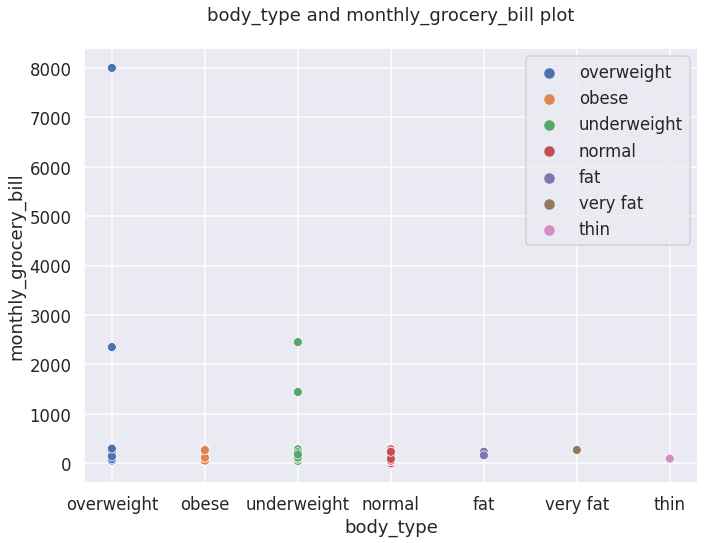

In [24]:
scatter_plot(df=df, x="body_type", y="monthly_grocery_bill", hue="body_type")

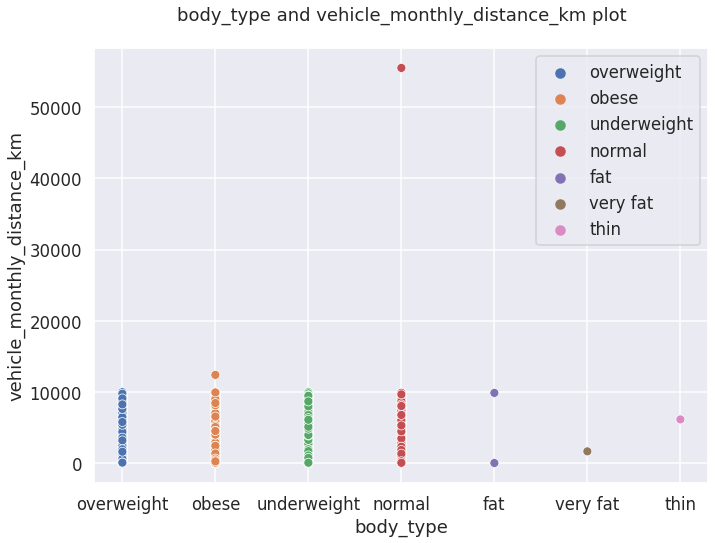

In [25]:
scatter_plot(df=df, x="body_type", y="vehicle_monthly_distance_km", hue="body_type")

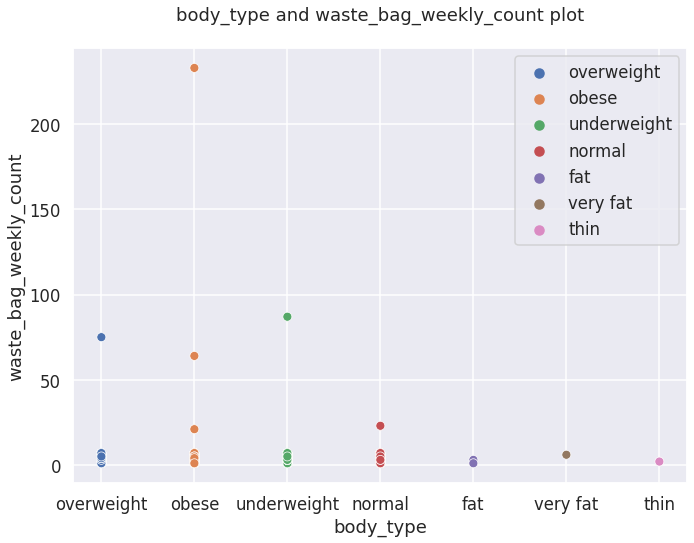

In [26]:
scatter_plot(df=df, x="body_type", y="waste_bag_weekly_count", hue="body_type")

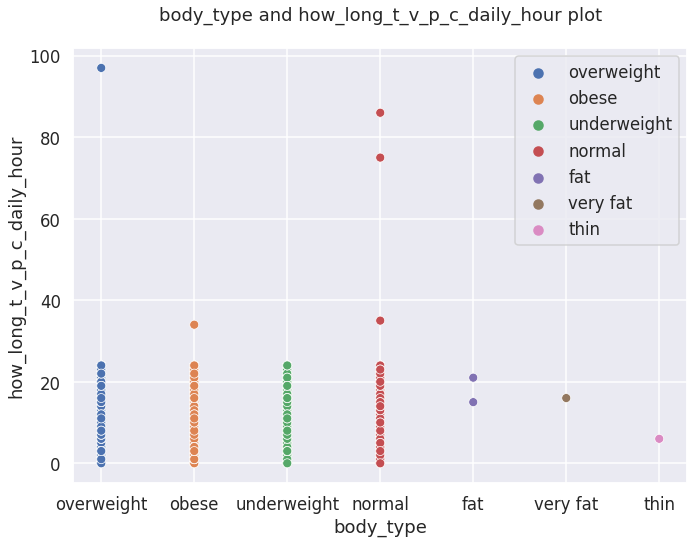

In [27]:
scatter_plot(df=df, x="body_type", y="how_long_t_v_p_c_daily_hour", hue="body_type")

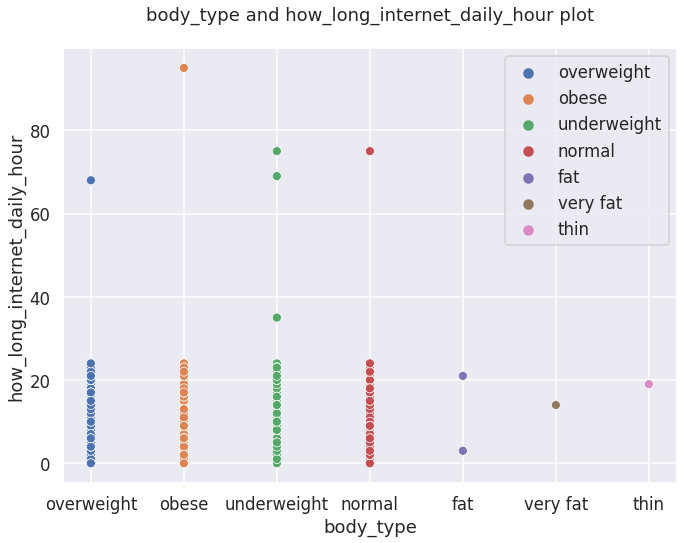

In [28]:
scatter_plot(df=df, x="body_type", y="how_long_internet_daily_hour", hue="body_type")

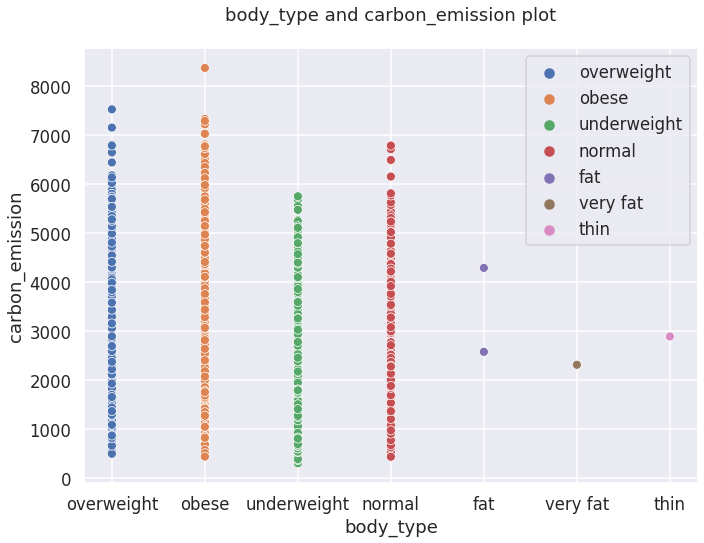

In [29]:
scatter_plot(df=df, x="body_type", y="carbon_emission", hue="body_type")

### 2.4.3 Coding Inconsistencies

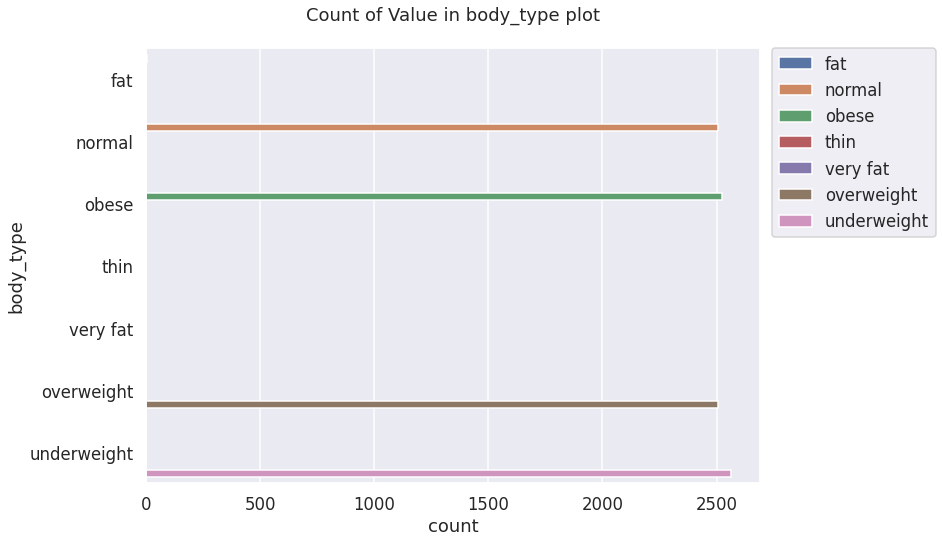

In [30]:
plot_column_value_count(df, "body_type")

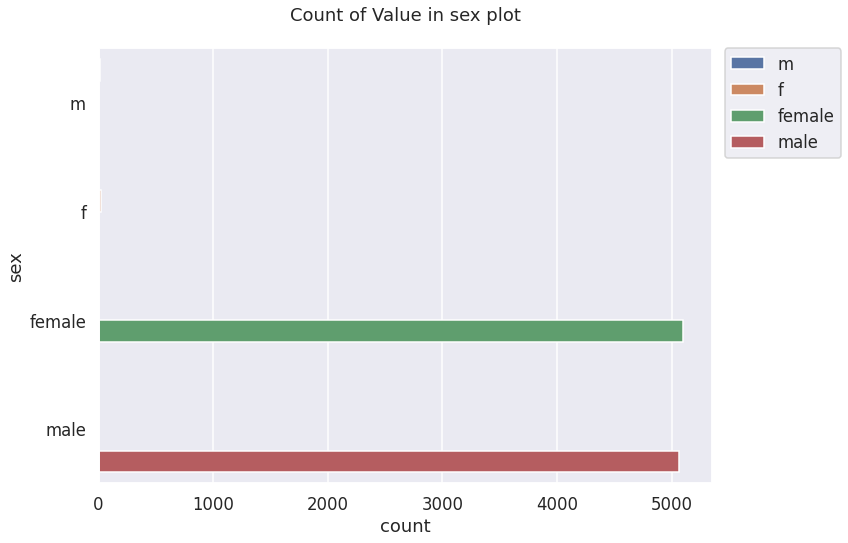

In [31]:
plot_column_value_count(df, "sex")